In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
sys.path.append('../../src/')
# import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

In [2]:
# Stationary Block Bootstrap 2.7.2 of Lahiri

def SB(X, p, N):
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # N: number of SB samples
     
    I = np.random.choice(len(X), N, replace=True)
    L = np.random.geometric(p=p, size=N)
    L[L<=20] = 20
    
    X_repeat = np.repeat(X, np.floor(np.max(L)/len(X))+1, axis=0)
#     print(np.mean(L))
    samples = []
    for i in range(len(I)):
        s = X_repeat[I[i]: I[i]+L[i]]
        samples.append(s)
    
    return samples

In [3]:
# def plot_compare_assets_across_risk_measures(risk_fn):
#     factor = 4
#     xsize = len(risk_measures)*factor
#     ysize = 1*factor

#     fig, axs = plt.subplots(1,len(risk_measures), figsize=(xsize, ysize), sharey=True)

#     for p, rm in enumerate(risk_measures):
#         HE_outer = []
#         for q, rn in enumerate(order):
#             if rm != 'CH':
#                 path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
#                 %(rn, rm)
#             else:
#                 path = '../../results/%s/MM/rh_cross_hedge.csv'\
#                 %(rn)    
#             _df = pd.read_csv(path)

#             B_rs = make_blocks(_df.rs, 1, 100)
#             B_rh = make_blocks(_df.rh, 1, 100)
#             _id = np.random.choice(range(len(B_rs)), 500 , replace=True)

#             HE = []
#             for i in _id:
#                 rho_rs = risk_fn(B_rs[i])
#                 rho_rh = risk_fn(B_rh[i])
#                 HE.append(1-rho_rh/rho_rs)
#             HE_outer.append(HE)

#         axs[p].boxplot(HE_outer)
#         axs[p].set_title(rm)

#     plt.tight_layout()
#     for p, a in enumerate(axs):
#         xtickNames = plt.setp(axs[p], xticklabels=coin_names)
#         plt.setp(xtickNames, rotation=90, fontsize=8)


In [4]:
def plot_compare_assets_across_risk_measures(risk_fn, SB_p, SB_N):
    factor = 4
    xsize = len(risk_measures)*factor
    ysize = 1*factor

    fig, axs = plt.subplots(1,len(risk_measures), figsize=(xsize, ysize), sharey=True)

    HE_outer2 = []
    for p, rm in enumerate(risk_measures):
        HE_outer = []
        for q, rn in enumerate(order):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)
        HE_outer2.append(HE_outer)

        axs[p].boxplot(HE_outer, showfliers=False)
        axs[p].set_title(rm)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=coin_names)
        plt.setp(xtickNames, rotation=90, fontsize=8)


In [5]:
def plot_compare_risk_measures_across_assets(risk_fn, SB_p, SB_N):
    factor = 4
    xsize = len(order)*factor
    ysize = 1*factor

    fig, axs = plt.subplots(1,len(order), figsize=(xsize, ysize), sharey=False)

    
    HE_outer2 = []
    for p, rn in enumerate(order):
        HE_outer = []
        for q, rm in enumerate(risk_measures):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)
        HE_outer2.append(HE_outer)

        axs[p].boxplot(HE_outer, showfliers=False)
        axs[p].set_title(rn)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=risk_measures)
        plt.setp(xtickNames, rotation=90, fontsize=8)
    
    return HE_outer2

\begin{tabular}{lllllll}
\toprule
{} &              Var &              ES5 &              ES1 &             VaR5 &             VaR1 &              ERM \\
\midrule
BTC     &            99.28 &            99.27 &            99.25 &            99.24 &            99.27 &            99.27 \\
        &   (98.38, 99.81) &   (98.38, 99.84) &   (98.01, 99.79) &   (98.40, 99.78) &   (98.00, 99.77) &   (98.17, 99.84) \\
CRIX    &            95.24 &            95.05 &            95.02 &            95.06 &            95.06 &            94.97 \\
        &   (82.59, 98.04) &   (86.54, 98.90) &   (85.86, 98.69) &   (85.86, 98.67) &   (86.86, 98.66) &   (85.84, 98.76) \\
BITX    &            94.70 &            94.78 &            94.70 &            94.87 &            94.86 &            94.74 \\
        &   (84.16, 97.87) &   (75.28, 98.40) &   (82.99, 98.16) &   (78.14, 97.89) &   (82.99, 98.09) &   (82.97, 97.98) \\
BITW100 &            92.64 &            93.05 &            92.88 &            92.69 &  

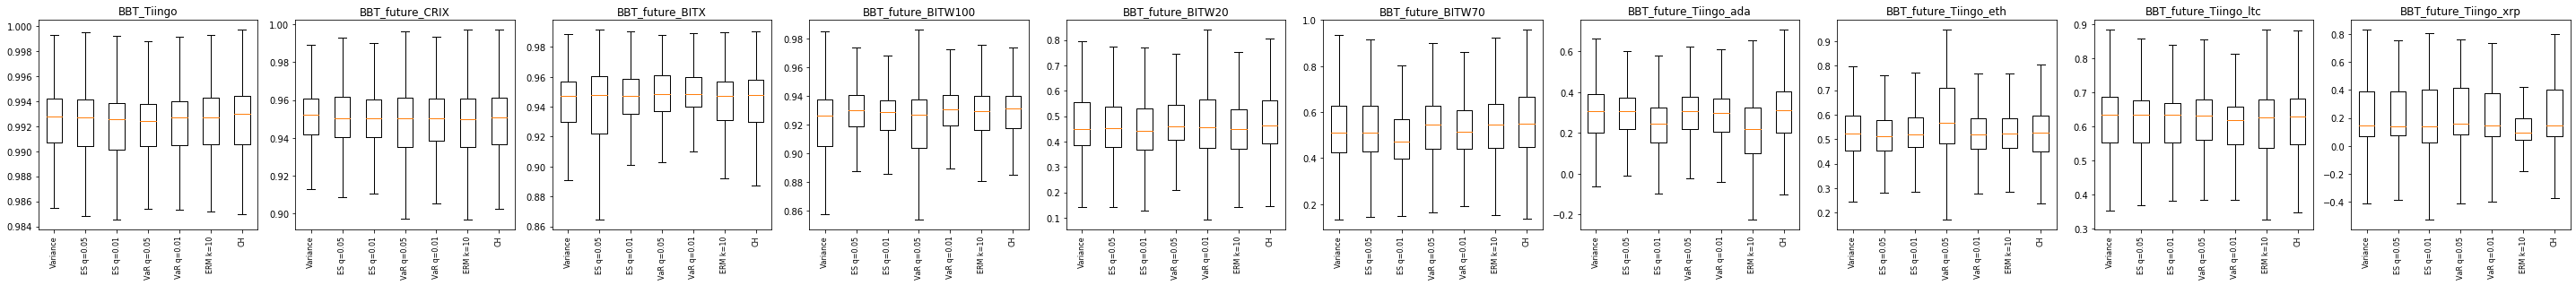

In [10]:
risk_fn = np.var
HE = plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)
DF = pd.DataFrame(HE)

mDF = pd.DataFrame(np.zeros(DF.shape))
q1DF = pd.DataFrame(np.zeros(DF.shape))
q3DF = pd.DataFrame(np.zeros(DF.shape))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        mDF.iloc[i,j]=np.median(DF.iloc[i,j])
        q1DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.025)
        q3DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.975)

mDF.columns = risk_measures
mDF.index = coin_names 

q1DF.columns  = risk_measures
q1DF.index  = coin_names

q3DF.columns  = risk_measures
q3DF.index  = coin_names

ResultDF = pd.DataFrame(np.zeros((DF.shape[0]*2, DF.shape[1])))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        m  = mDF.iloc[i, j] *100
        q1 = q1DF.iloc[i, j] *100
        q3 = q3DF.iloc[i, j] *100
        ResultDF.iloc[2*i, j] = '%.2f'%m
        ResultDF.iloc[2*i+1, j] = '(%.2f, %.2f)'%(q1, q3)

ResultDF.columns = ['Var', 'ES5', 'ES1', 'VaR5', 'VaR1', 'ERM', 'CH']

new_coin_names = ['BTC', '', 'CRIX', '', 'BITX','', 'BITW100', '','BITW20','', 'BITW70','',
                  'ADA','', 'ETH','', 'LTC','', 'XRP', '',]

ResultDF.index = new_coin_names
ResultDF = ResultDF.iloc[:, :-1]
print(ResultDF.to_latex())
# varResultDF.to_latex()

\begin{tabular}{lllllll}
\toprule
{} &               Var &               ES5 &               ES1 &              VaR5 &              VaR1 &               ERM \\
\midrule
BTC     &             89.53 &             89.61 &             90.06 &             89.28 &             89.56 &             89.70 \\
        &    (76.12, 96.61) &    (74.80, 96.50) &    (72.73, 96.08) &    (72.48, 97.00) &    (76.06, 97.11) &    (76.21, 96.82) \\
CRIX    &             82.86 &             83.88 &             82.61 &             83.00 &             83.88 &             83.87 \\
        &    (17.60, 94.06) &    (28.77, 96.97) &    (17.49, 93.35) &    (17.42, 94.86) &    (17.68, 98.17) &    (17.64, 96.71) \\
BITX    &             79.13 &             79.43 &             79.06 &             80.48 &             79.66 &             79.09 \\
        &    (14.24, 94.51) &    (12.27, 95.93) &     (7.56, 95.92) &    (15.20, 97.22) &    (17.52, 95.62) &    (14.24, 94.82) \\
BITW100 &             76.72 &             76.

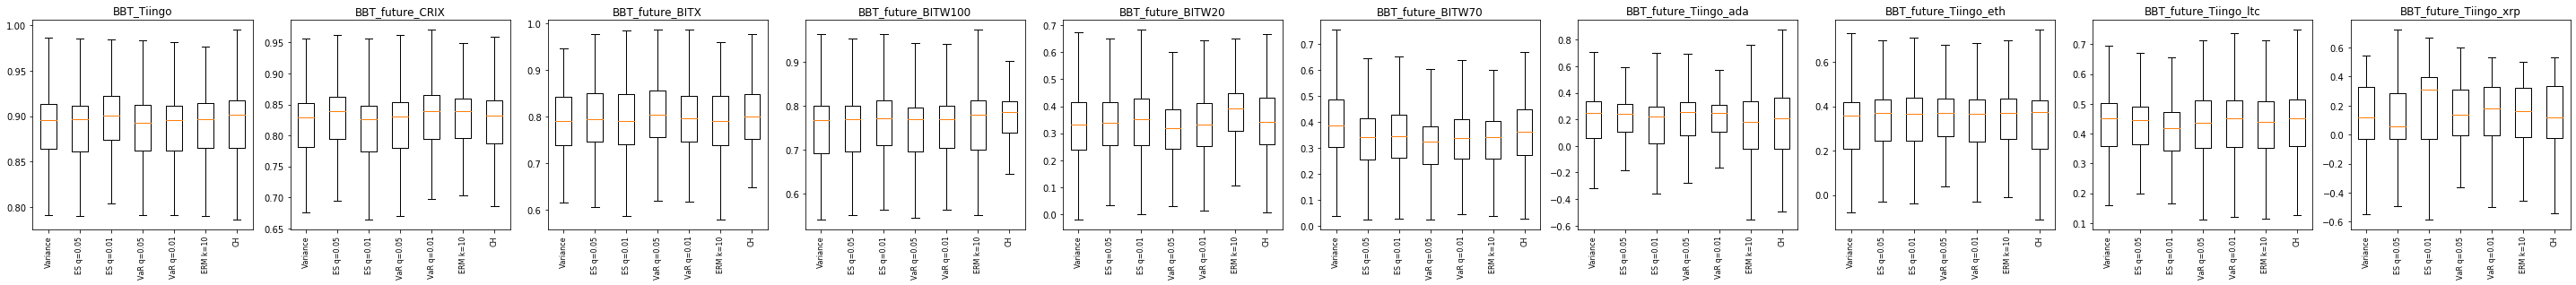

In [11]:
risk_fn = lambda x: ES(0.05, x)
HE = plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)
DF = pd.DataFrame(HE)

mDF = pd.DataFrame(np.zeros(DF.shape))
q1DF = pd.DataFrame(np.zeros(DF.shape))
q3DF = pd.DataFrame(np.zeros(DF.shape))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        mDF.iloc[i,j]=np.median(DF.iloc[i,j])
        q1DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.025)
        q3DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.975)

mDF.columns = risk_measures
mDF.index = coin_names 

q1DF.columns  = risk_measures
q1DF.index  = coin_names

q3DF.columns  = risk_measures
q3DF.index  = coin_names

ResultDF = pd.DataFrame(np.zeros((DF.shape[0]*2, DF.shape[1])))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        m  = mDF.iloc[i, j] *100
        q1 = q1DF.iloc[i, j] *100
        q3 = q3DF.iloc[i, j] *100
        ResultDF.iloc[2*i, j] = '%.2f'%m
        ResultDF.iloc[2*i+1, j] = '(%.2f, %.2f)'%(q1, q3)

ResultDF.columns = ['Var', 'ES5', 'ES1', 'VaR5', 'VaR1', 'ERM', 'CH']

new_coin_names = ['BTC', '', 'CRIX', '', 'BITX','', 'BITW100', '','BITW20','', 'BITW70','',
                  'ADA','', 'ETH','', 'LTC','', 'XRP', '',]

ResultDF.index = new_coin_names
ResultDF = ResultDF.iloc[:, :-1]
print(ResultDF.to_latex())
# varResultDF.to_latex()

\begin{tabular}{lllllll}
\toprule
{} &               Var &                ES5 &               ES1 &              VaR5 &              VaR1 &               ERM \\
\midrule
BTC     &             90.28 &              90.41 &             89.67 &             90.53 &             89.95 &             90.26 \\
        &    (79.82, 97.26) &     (76.94, 97.38) &    (76.12, 97.22) &   (63.24, 114.09) &    (79.04, 98.47) &    (77.22, 98.50) \\
CRIX    &             81.50 &              82.91 &             81.13 &             81.96 &             81.21 &             81.24 \\
        &    (19.30, 94.66) &    (43.11, 134.78) &    (16.91, 95.80) &    (20.19, 97.03) &     (3.99, 95.20) &    (-2.93, 94.49) \\
BITX    &             78.66 &              78.51 &             78.62 &             78.64 &             77.79 &             78.48 \\
        &    (-2.26, 97.78) &    (-27.79, 98.56) &    (14.26, 98.19) &    (25.67, 98.39) &     (0.40, 94.60) &   (-14.88, 99.22) \\
BITW100 &             74.92 &         

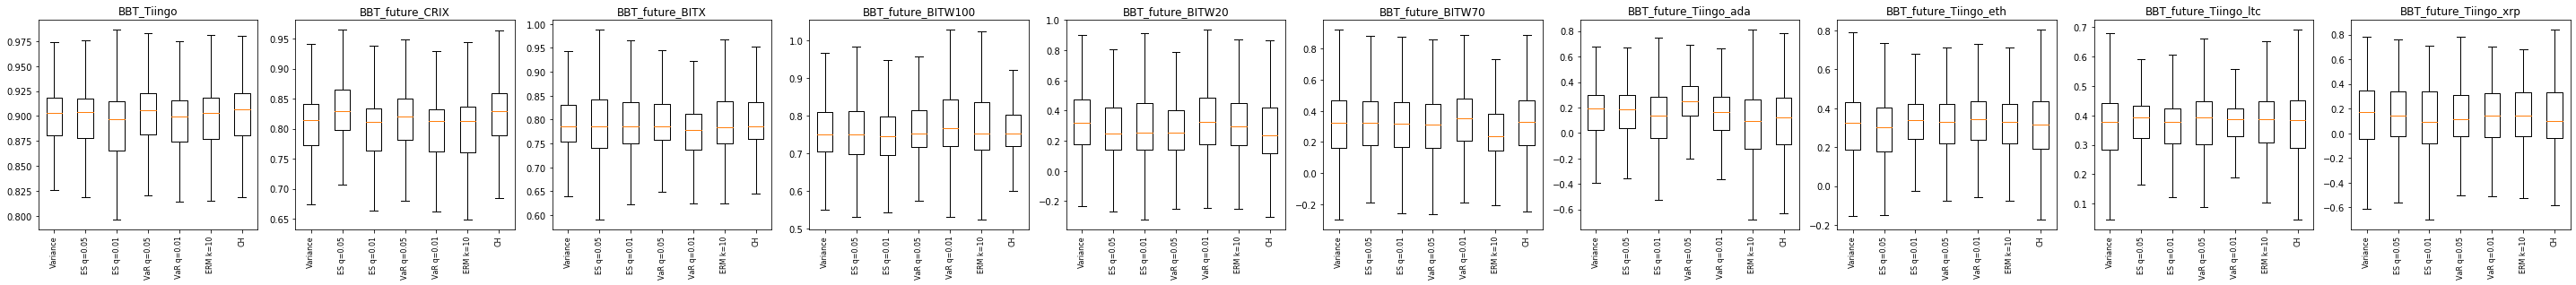

In [16]:
risk_fn = lambda x: ERM_estimate_trapezoidal(10, x)
HE = plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)
DF = pd.DataFrame(HE)

mDF = pd.DataFrame(np.zeros(DF.shape))
q1DF = pd.DataFrame(np.zeros(DF.shape))
q3DF = pd.DataFrame(np.zeros(DF.shape))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        mDF.iloc[i,j]=np.median(DF.iloc[i,j])
        q1DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.025)
        q3DF.iloc[i,j]=np.quantile(DF.iloc[i,j], 0.975)

mDF.columns = risk_measures
mDF.index = coin_names 

q1DF.columns  = risk_measures
q1DF.index  = coin_names

q3DF.columns  = risk_measures
q3DF.index  = coin_names

ResultDF = pd.DataFrame(np.zeros((DF.shape[0]*2, DF.shape[1])))

for i in range(DF.shape[0]):
    for j in range(DF.shape[1]):
        m  = mDF.iloc[i, j] *100
        q1 = q1DF.iloc[i, j] *100
        q3 = q3DF.iloc[i, j] *100
        ResultDF.iloc[2*i, j] = '%.2f'%m
        ResultDF.iloc[2*i+1, j] = '(%.2f, %.2f)'%(q1, q3)

ResultDF.columns = ['Var', 'ES5', 'ES1', 'VaR5', 'VaR1', 'ERM', 'CH']

new_coin_names = ['BTC', '', 'CRIX', '', 'BITX','', 'BITW100', '','BITW20','', 'BITW70','',
                  'ADA','', 'ETH','', 'LTC','', 'XRP', '',]

ResultDF.index = new_coin_names
ResultDF = ResultDF.iloc[:, :-1]
print(ResultDF.to_latex())
# varResultDF.to_latex()

In [21]:
def plot_compare_assets_across_risk_measures_2(risk_fn, SB_p, SB_N, savepath):
    factor = 4.5
    xsize = 3*factor
    ysize = 2*factor

    fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

    HE_outer2 = []
    for p, rm in enumerate(risk_measures[:-1]):
        HE_outer = []
        for q, rn in enumerate(order):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)
        HE_outer2.append(HE_outer)

        if p<=2:
            axs[0, p].boxplot(HE_outer, showfliers=False)
            axs[0, p].set_title(rm)
            
        else:
            axs[1, p-3].boxplot(HE_outer, showfliers=False)
            axs[1, p-3].set_title(rm, fontsize=12)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=coin_names)
        plt.setp(xtickNames, rotation=90, fontsize=12)
    
    plt.subplots_adjust(bottom=0.15)
    plt.savefig(savepath, transparent=True)

In [22]:
def plot_compare_risk_measures_across_assets(risk_fn, SB_p, SB_N, savepath):
    factor = 4
    xsize = 3*factor
    ysize = 2*factor

    fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

    
    HE_outer2 = []
    for p, rn in enumerate(order):
        HE_outer = []
        for q, rm in enumerate(risk_measures):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)
        HE_outer2.append(HE_outer)

        if p<=2:
            axs[0, p].boxplot(HE_outer, showfliers=False)
            axs[0, p].set_title(rm)
            
        else:
            axs[1, p-3].boxplot(HE_outer, showfliers=False)
            axs[1, p-3].set_title(rm)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=risk_measures)
        plt.setp(xtickNames, rotation=90, fontsize=8)
    
    plt.savefig(savepath, transparent=True)
    return HE_outer2

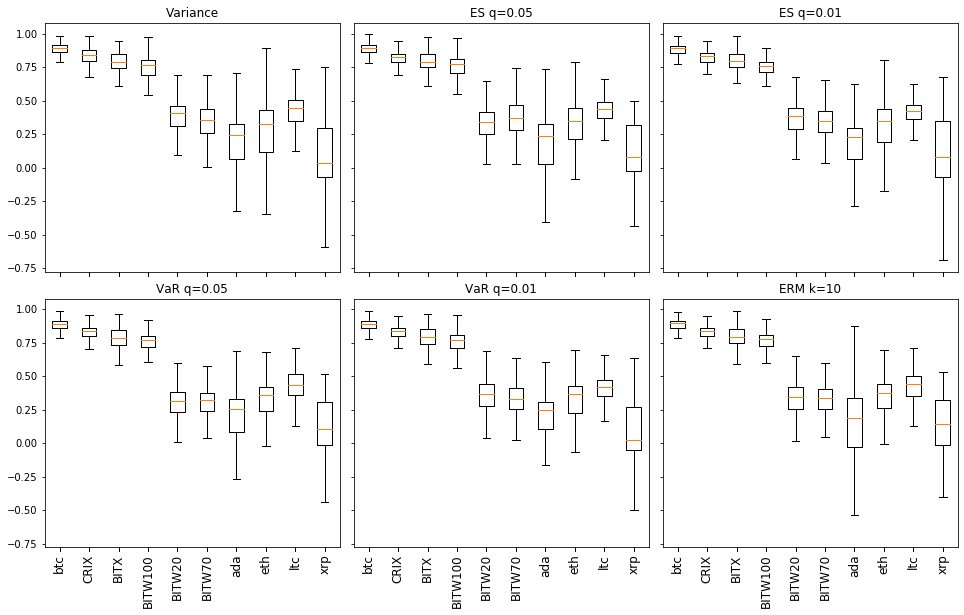

In [23]:
risk_fn = lambda x: ES(0.05, x)
plot_compare_assets_across_risk_measures_2(risk_fn, 1/200, 1000, '../../latex/_pics/ES5_HE_boxplot.pdf')
# plot_compare_assets_across_risk_measures_2(risk_fn, 1/200, 1000, 'ERM_HE_boxplot.png')


In [ ]:
risk_fn = lambda x: ES(0.05, x)
# plot_compare_assets_across_risk_measures_2(risk_fn, 1/200, 1000, 'ES5_HE_boxplot.png')
plot_compare_assets_across_risk_measures_2(risk_fn, 1/200, 1000, 'ERM_HE_boxplot.png')


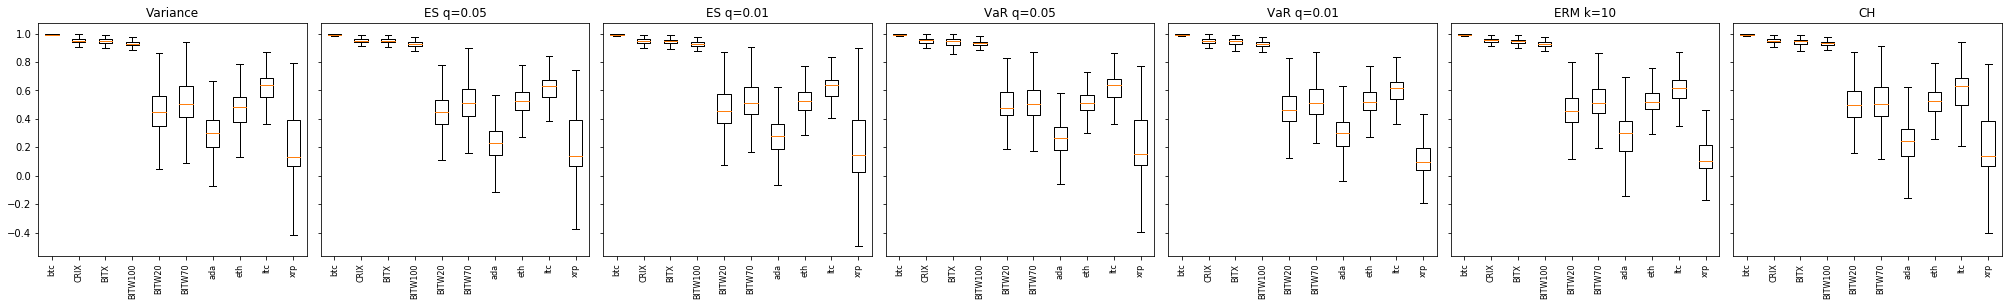

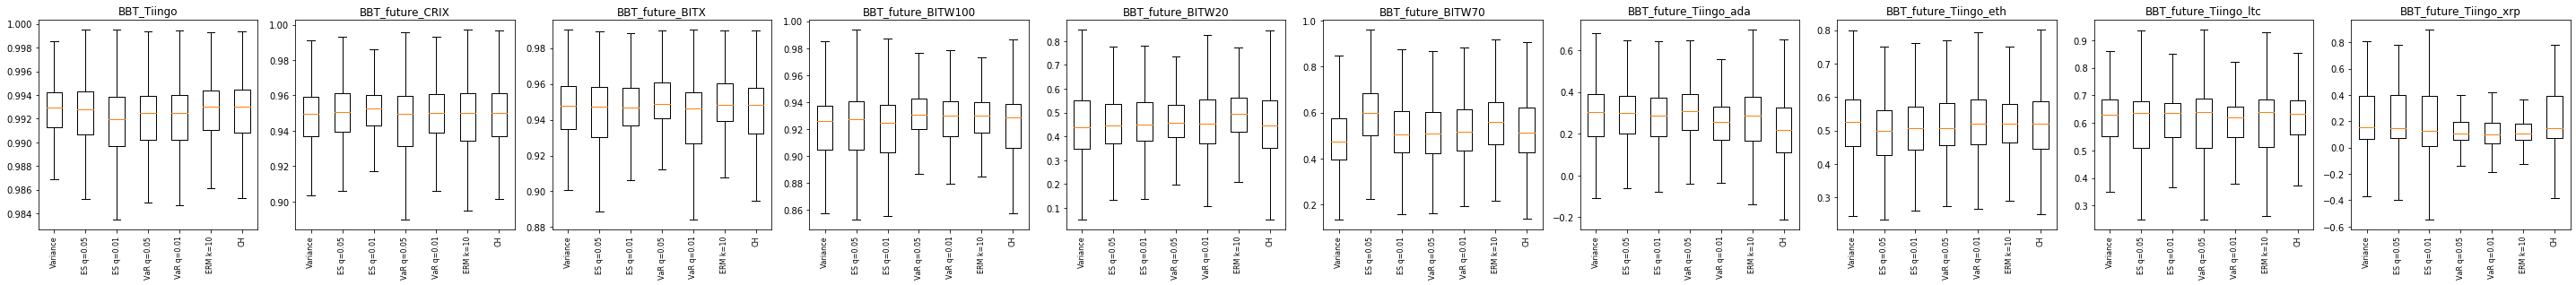

In [29]:
# Variance
risk_fn = np.var
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

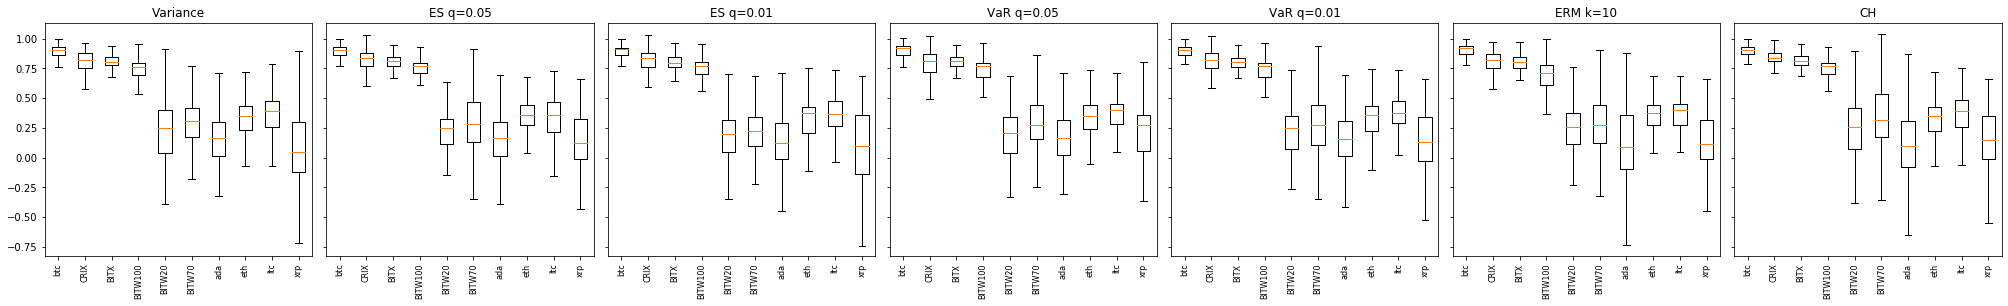

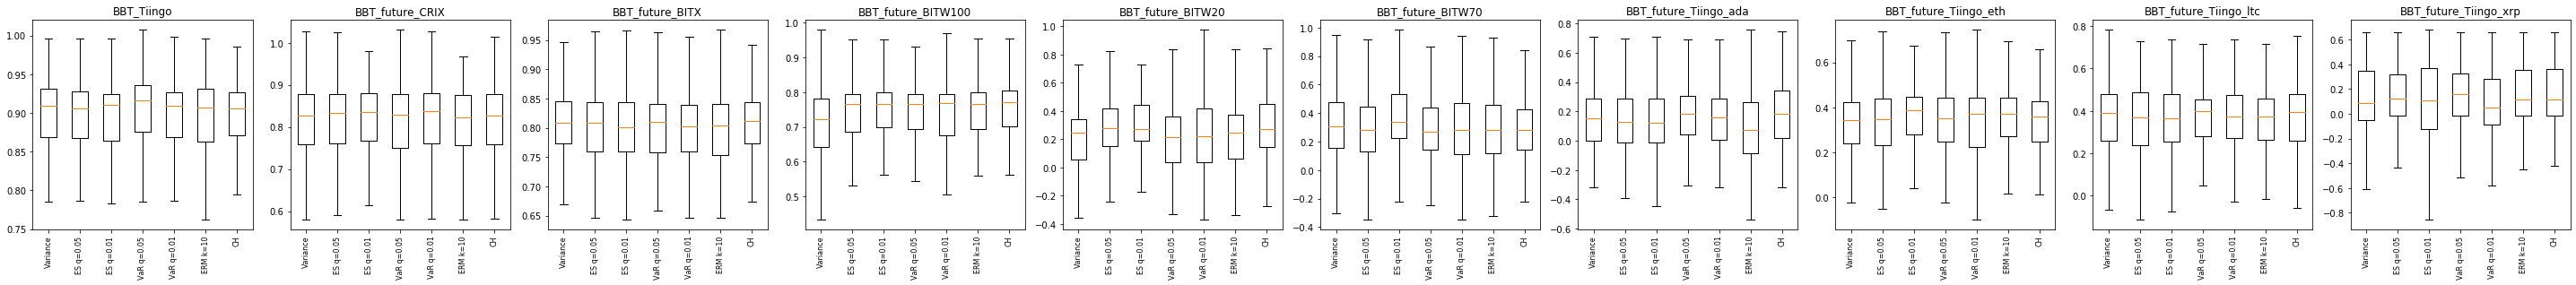

In [28]:
# Value at Risk 5%
risk_fn = lambda x: VaR(0.05, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

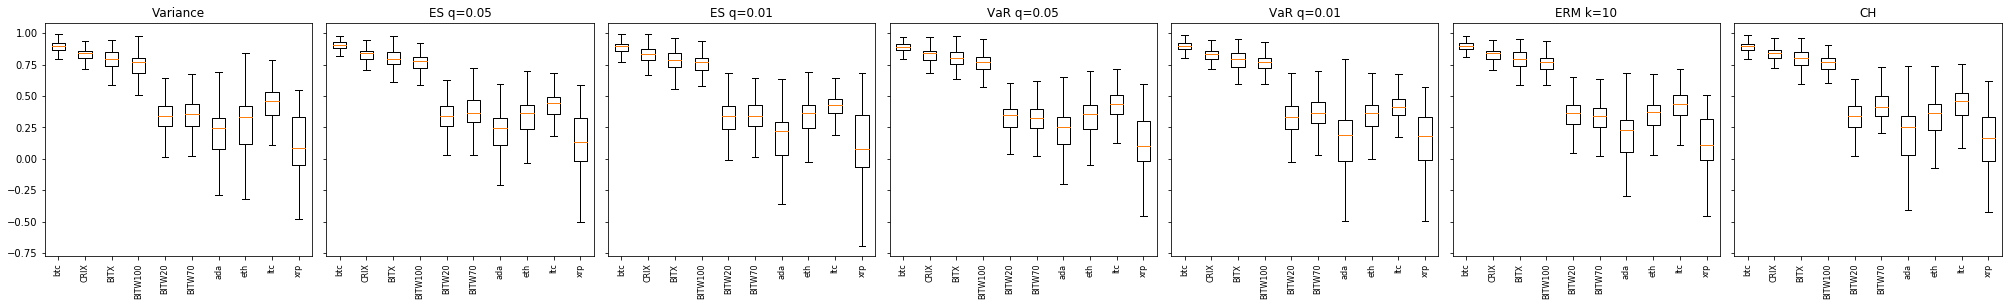

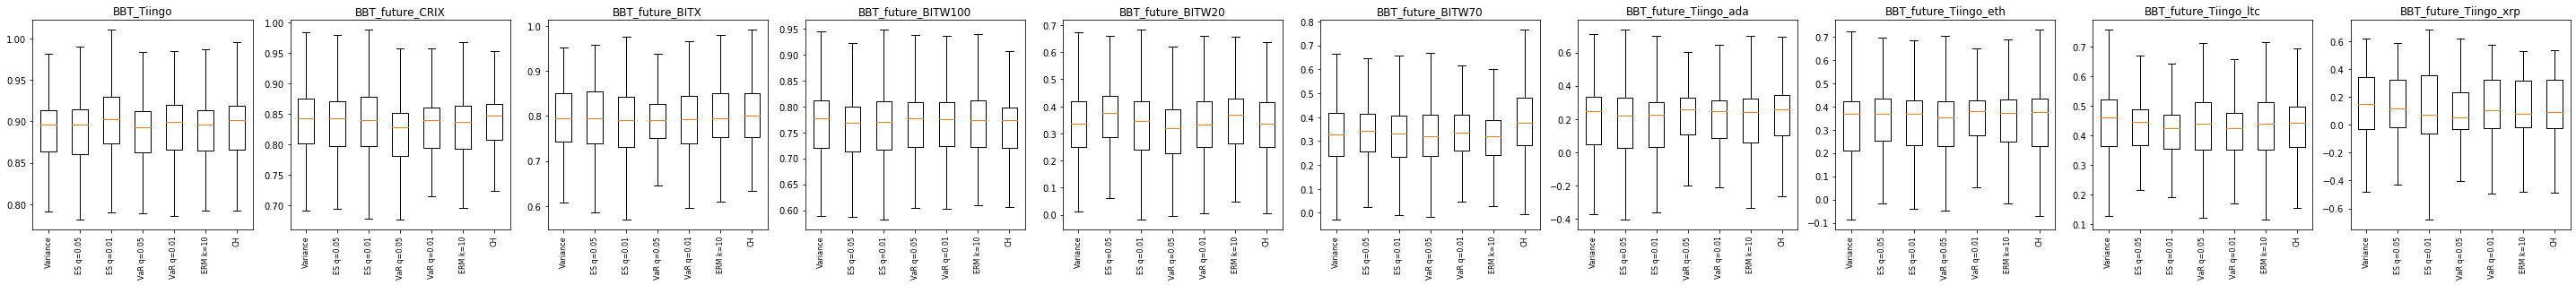

In [27]:
# Expected Shortfall 5%
risk_fn = lambda x: ES(0.05, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

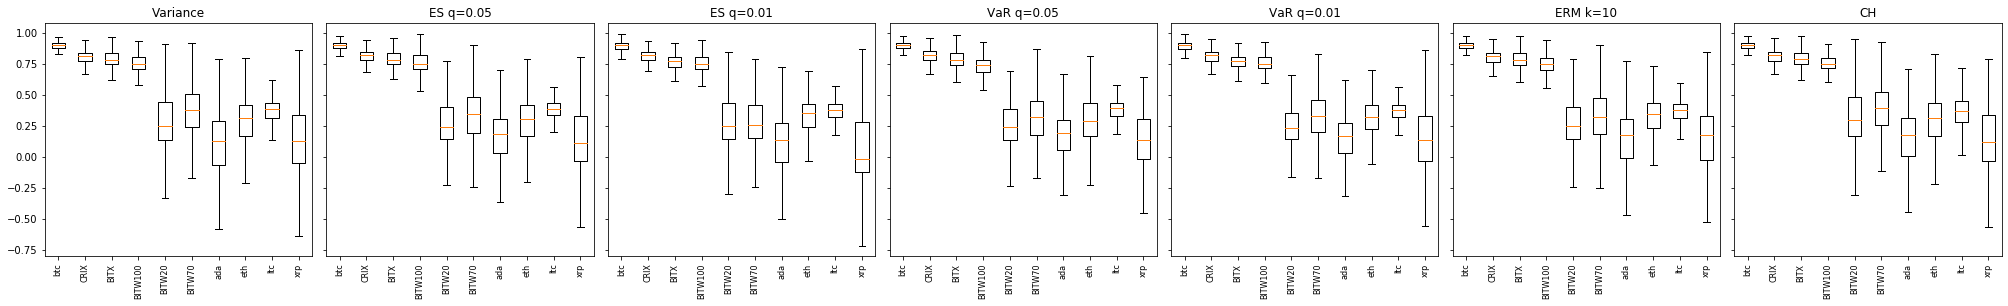

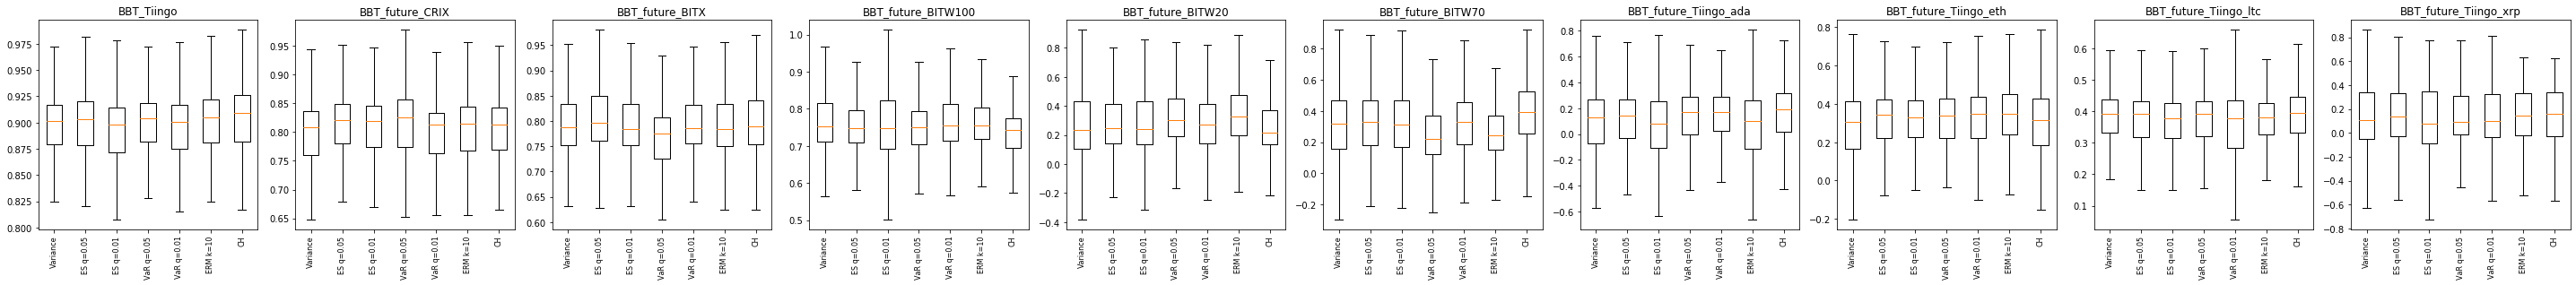

In [25]:
# ERM k=10
risk_fn = lambda x: ERM_estimate_trapezoidal(10, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

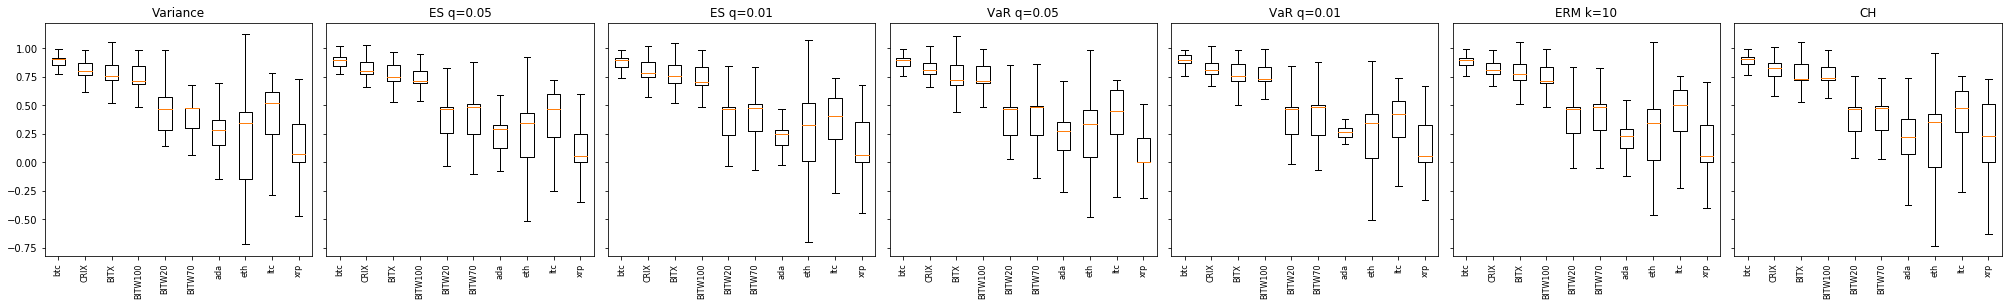

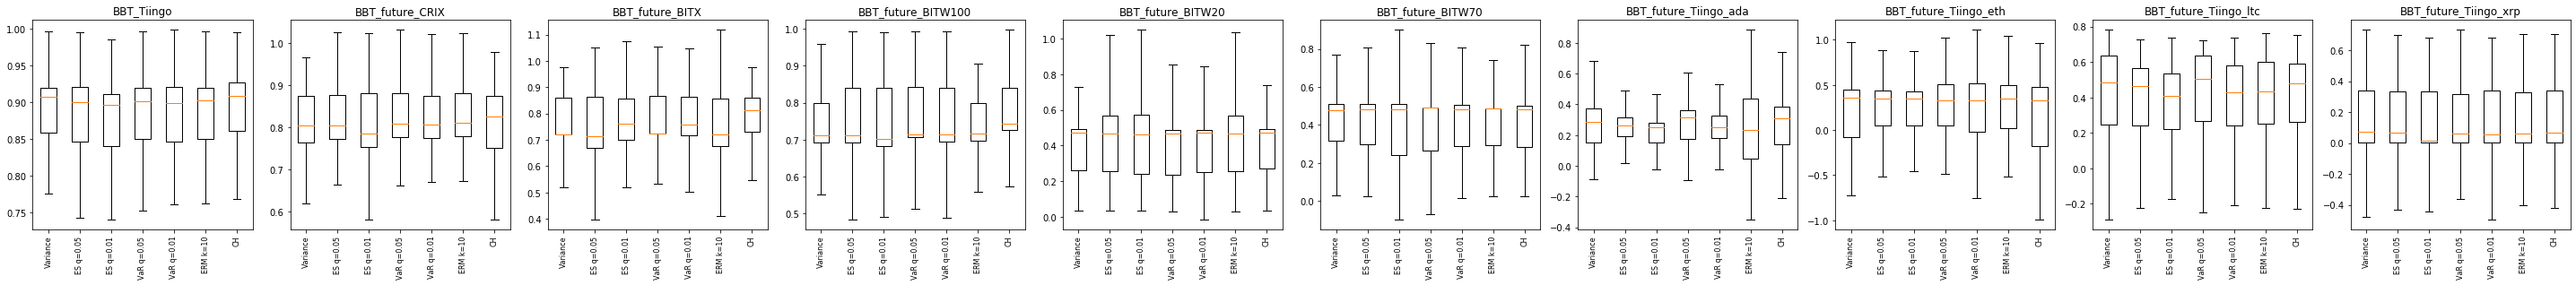

In [26]:
# Maximum Drawdown
risk_fn = np.min
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

In [471]:
risk_outer = []

N = 100

p = 1/200

# risk_fn = lambda x: ERM_estimate_trapezoidal(10, x)

risk_fn = lambda x: ES(0.05, x)

for rn in order[0:1]:

    path = '../../results/%s/MM/rh_cross_hedge.csv'\
                    %(rn)    
    _df = pd.read_csv(path)

    samples = SB(np.array(_df.loc[:,['rh', 'rs']]), p, N)

    risk = []

    for s in samples:
        risk_rh = risk_fn(s[:,0])
        risk_rs = risk_fn(s[:,1])
        risk.append(1-risk_rh/risk_rs)
        print(risk_rh, risk_rs, len(s))


    risk = np.array(risk)
    
    risk_outer.append(risk)
    print(rn)

0.00950141951046761 0.11635330247590134 121
0.006831433535822273 0.12097827698279305 74
0.007721681676627223 0.07204369115266775 185
0.012038010898095856 0.0619513080748815 71
0.01049704007874768 0.11345996552040194 178
0.009476832988635053 0.08527045663800228 378
0.002566798473162057 0.0600293139003604 17
0.008649570450508065 0.04583934871103187 117
0.0025527352768377944 0.0642537782044449 8
0.006079357573724787 0.07717211169749069 163
0.009281429022363095 0.09763271973994281 253
0.009185503355364132 0.05359062401074457 105
0.00890729950195305 0.11637777180099884 317
0.014155733910051952 0.1018866176984044 32
0.0015735656605358336 0.013196169962525 5
0.007730947562595001 0.11283398356466444 416
0.009320812825108177 0.0926480179994272 290
0.0027743835341000195 0.1185061713452199 12
0.00499207493953643 0.07977933287226986 97
0.01121000160380177 0.11886552175169396 112
0.008562046081793331 0.05732621052519582 157
0.0052938402211383 0.060440228573264546 72
0.008075098531929632 0.058052585

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > s

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.ty

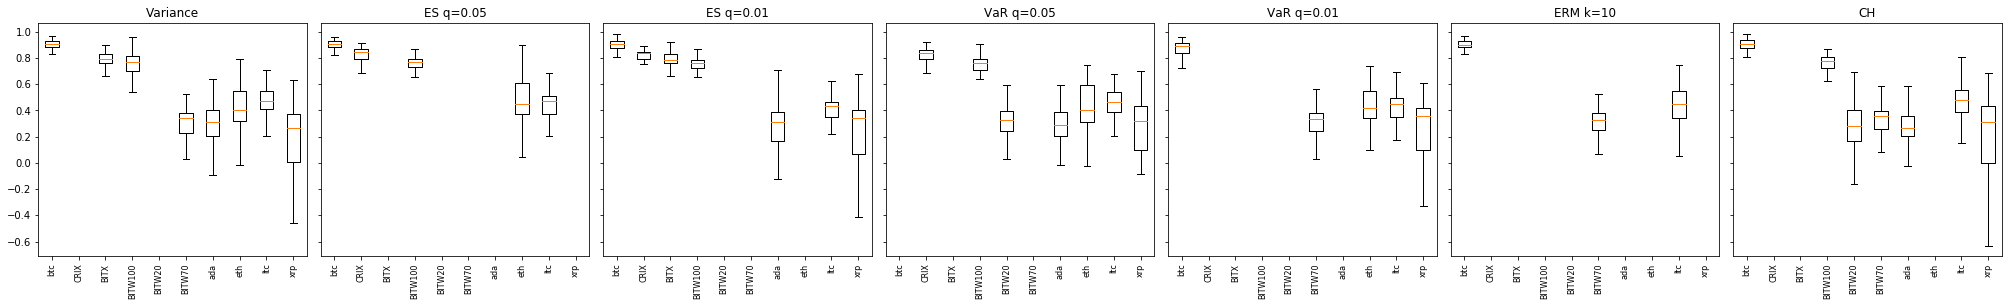

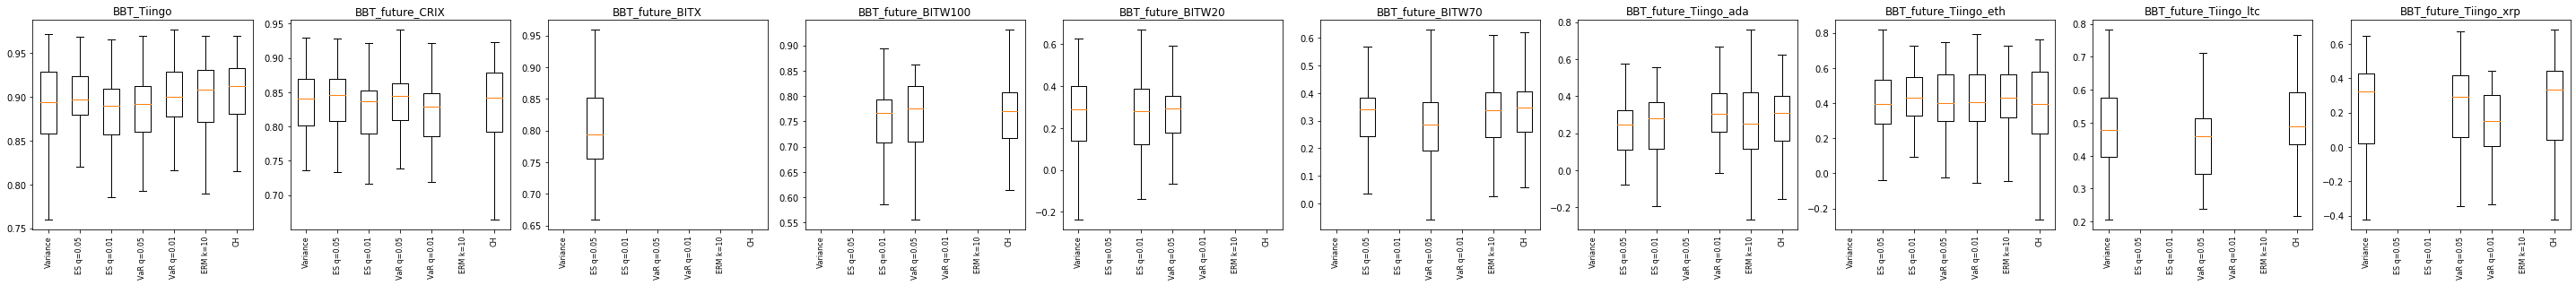

In [463]:
risk_fn = lambda x: ES(0.05, x)

plot_compare_assets_across_risk_measures(risk_fn, 1/200, 100)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 100)

In [31]:
rn = 'BBT_future_CRIX'

path = '../../results/%s/MM/rh_cross_hedge.csv'\
%(rn)    
_df = pd.read_csv(path)

Text(0.5, 0, 'h')

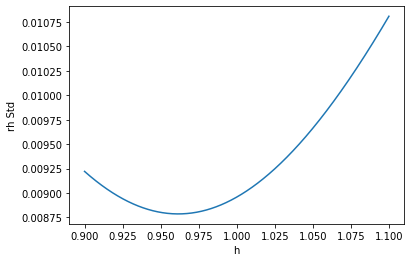

In [36]:
h_arr = np.linspace(0.9,1.1, 1000)

rh_arr = []
for h in h_arr:
    rh = np.std(_df.rs - h*_df.rf)
    rh_arr.append(rh)
    
plt.plot(h_arr, rh_arr)
plt.ylabel('rh Std')
plt.xlabel('h')

Text(0.5, 0, 'h')

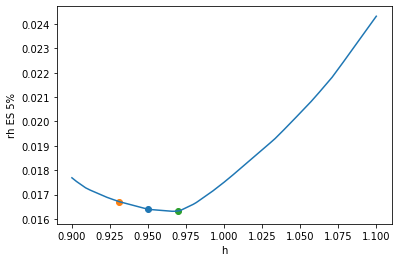

In [46]:
h_arr = np.linspace(0.9,1.1, 1000)

rh_arr = []
for h in h_arr:
    rh = ES(0.05, _df.rs - h*_df.rf)
    rh_arr.append(rh)
    
plt.plot(h_arr, rh_arr)

mean_h = np.mean(_df.h)
mean_rho = ES(0.05, _df.rs-mean_h*_df.rf)

min_h = np.min(_df.h)
min_rho = ES(0.05, _df.rs-min_h*_df.rf)

max_h = np.max(_df.h)
max_rho = ES(0.05, _df.rs-max_h*_df.rf)

plt.scatter(mean_h, mean_rho)
plt.scatter(min_h, min_rho)
plt.scatter(max_h, max_rho)

plt.ylabel('rh ES 5%')
plt.xlabel('h')

In [40]:
np.mean(_df.h)

0.9500689216257928

In [5]:
LB = 0.95


LTVH = 0.92


LB/(2*LB-LTVH)



0.9693877551020409